In [21]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, shapiro, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scripts.utils import rank_biserial

In [22]:
# File paths
path_interactions_6h = "../../csv_data/interactions/nonsem_interactions_6h.csv"
path_interactions_1b5h = "../../csv_data/interactions/nonsem_interactions_1b5h.csv"
path_interactions_3b3h = "../../csv_data/interactions/nonsem_interactions_3b3h.csv"


# Load the CSV files into DataFrames
df_interactions_6h = pd.read_csv(path_interactions_6h)
df_interactions_1b5h = pd.read_csv(path_interactions_1b5h)
df_interactions_3b3h = pd.read_csv(path_interactions_3b3h)

### Difference in copying behavior: 1B5H vs. 3B3H (All)

In [23]:
# Extract the 'items_copied' columns
items_copied_6h = df_interactions_6h['items_copied']
items_copied_1b5h = df_interactions_1b5h['items_copied']
items_copied_3b3h = df_interactions_3b3h['items_copied']

In [24]:
# Check normality assumption
shapiro_6h = shapiro(items_copied_6h)
shapiro_1b5h = shapiro(items_copied_1b5h)
shapiro_3b3h = shapiro(items_copied_3b3h)

print(f"P-value of Shapiro-Wilk test for 6h: {shapiro_6h[1]}")
print(f"P-value of Shapiro-Wilk test for 1b5h: {shapiro_1b5h[1]}")
print(f"P-value of Shapiro-Wilk test for 3b3h: {shapiro_3b3h[1]}")

P-value of Shapiro-Wilk test for 6h: 7.607557262088692e-23
P-value of Shapiro-Wilk test for 1b5h: 2.163566738560874e-12
P-value of Shapiro-Wilk test for 3b3h: 6.785432736114043e-09


In [29]:
# If normality is violated in either group, use Mann-Whitney U test
if shapiro_1b5h.pvalue < 0.05 or shapiro_3b3h.pvalue < 0.05 and shapiro_6h.pvalue < 0.05:
    print("Normality is violated. Apply Mann-Whitney U test.")
    mannwhitney_test_1b5h_6h = mannwhitneyu(items_copied_1b5h, items_copied_6h, alternative='greater')
    mannwhitney_test_3b3h_6h = mannwhitneyu(items_copied_3b3h, items_copied_6h, alternative='greater')
    mannwhitney_test_3b3h_1b5h = mannwhitneyu(items_copied_3b3h, items_copied_1b5h, alternative='greater')
    
    print(f"Mann-Whitney U test (1B5H vs. 6H): {mannwhitney_test_1b5h_6h}")
    print(f"Mann-Whitney U test (3B3H vs. 6H): {mannwhitney_test_3b3h_6h}")
    print(f"Mann-Whitney U test (3B3H vs. 1B5H): {mannwhitney_test_3b3h_1b5h}")

Normality is violated. Apply Mann-Whitney U test.
Mann-Whitney U test (1B5H vs. 6H): MannwhitneyuResult(statistic=20282.0, pvalue=0.7732891210847539)
Mann-Whitney U test (3B3H vs. 6H): MannwhitneyuResult(statistic=23378.0, pvalue=0.04304904589653512)
Mann-Whitney U test (3B3H vs. 1B5H): MannwhitneyuResult(statistic=6226.0, pvalue=0.02273225484350146)


In [31]:
# Calculate Effect Size (r) for Mann-Whitney U test
effect_size_copying_1b5h_6h = rank_biserial(items_copied_1b5h, items_copied_6h)
effect_size_copying_3b3h_6h = rank_biserial(items_copied_3b3h, items_copied_6h)
effect_size_copying_3b3h_1b5h = rank_biserial(items_copied_3b3h, items_copied_1b5h)

print(f"Effect size (r) for copying behaviour (1B5H vs. 6H): {effect_size_copying_1b5h_6h}")
print(f"Effect size (r) for copying behaviour (3B3H vs. 6H): {effect_size_copying_3b3h_6h}")
print(f"Effect size (r) for copying behaviour (3B3H vs. 1B5H): {effect_size_copying_3b3h_1b5h}")

Effect size (r) for copying behaviour (1B5H vs. 6H): -0.044023378582202066
Effect size (r) for copying behaviour (3B3H vs. 6H): 0.10190422322775272
Effect size (r) for copying behaviour (3B3H vs. 1B5H): 0.15125739644970415


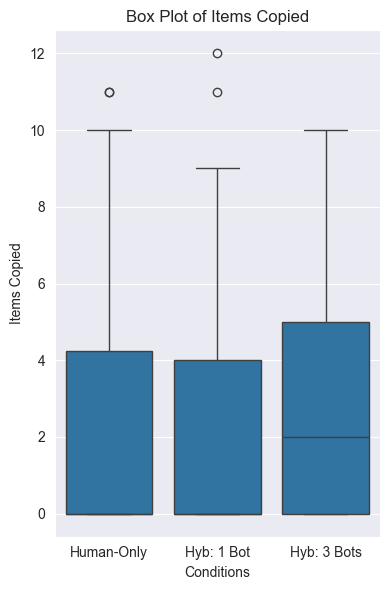

In [32]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Condition': ['Human-Only'] * len(items_copied_6h) + ['Hyb: 1 Bot'] * len(items_copied_1b5h) + ['Hyb: 3 Bots'] * len(items_copied_3b3h),
    'Items_Copied': list(items_copied_6h) + list(items_copied_1b5h) + list(items_copied_3b3h)
})

# Plotting box plot
plt.figure(figsize=(4, 6))
sns.boxplot(x='Condition', y='Items_Copied', data=df_plot)
plt.title('Box Plot of Items Copied')
plt.xlabel('Conditions')
plt.ylabel('Items Copied')
plt.tight_layout()

# Save the plot as a PDF file
output_path = "../../plots/interactions/box_plot_items_copied.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

### Relationship between copying behavior and score

In [33]:
# Combine the two DataFrames
df_combined = pd.concat([df_interactions_6h, df_interactions_1b5h, df_interactions_3b3h])

# Apply log transformation to the scores to handle skewness and reduce the impact of outliers
df_combined['log_score'] = np.log1p(df_combined['score'])

# Check normality of 'log_score'
shapiro_log_score = shapiro(df_combined['log_score'])
print(f"Shapiro-Wilk test for log_score: {shapiro_log_score}")

if shapiro_log_score[1] < 0.05:
    print("The log-transformed score is not normally distributed. Apply Spearman correlation.")
    # Calculate Spearman correlation on log-transformed score
    spearman_corr_log, spearman_p_value_log = spearmanr(df_combined['items_copied'], df_combined['log_score'])
    print(f"Spearman correlation (log score): {spearman_corr_log} (p-value: {spearman_p_value_log})")
else:
    print("The log-transformed score is normally distributed. Apply Pearson correlation.")
    # Calculate Pearson correlation on log-transformed score
    pearson_corr_log, pearson_p_value_log = pearsonr(df_combined['items_copied'], df_combined['log_score'])
    print(f"Pearson correlation (log score): {pearson_corr_log} (p-value: {pearson_p_value_log})")

Shapiro-Wilk test for log_score: ShapiroResult(statistic=0.8362917630333371, pvalue=1.1828792405008454e-24)
The log-transformed score is not normally distributed. Apply Spearman correlation.
Spearman correlation (log score): 0.826002200871471 (p-value: 5.226380208657885e-155)


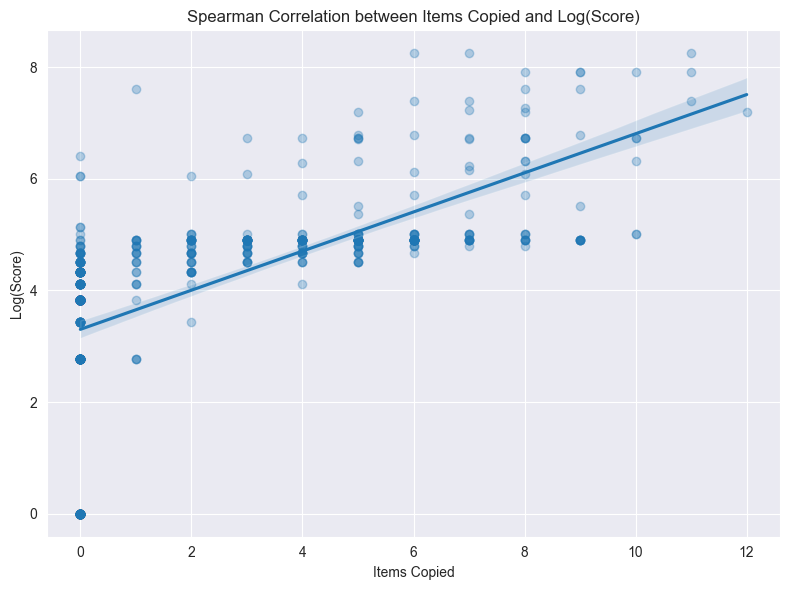

In [34]:
# Visualize the relationship with a scatter plot and regression line (log-transformed score)
plt.figure(figsize=(8, 6))
sns.regplot(x='items_copied', y='log_score', data=df_combined, scatter_kws={'alpha':0.3})
plt.title('Spearman Correlation between Items Copied and Log(Score)')
plt.xlabel('Items Copied')
plt.ylabel('Log(Score)')
plt.tight_layout()

# Save the plot as a PDF file
output_path = "../../plots/interactions/scatter_plot_items_copied_score.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

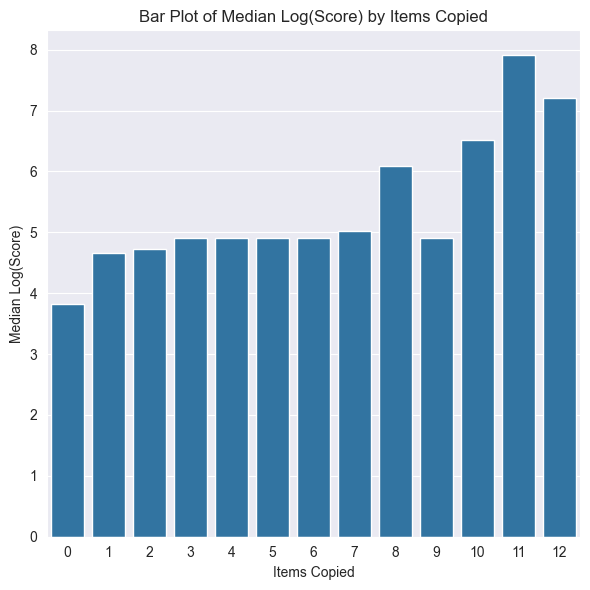

In [35]:
# Aggregate visualization by median
df_aggregated = df_combined.groupby('items_copied').agg({'log_score': 'median'}).reset_index()
plt.figure(figsize=(6, 6))
sns.barplot(x='items_copied', y='log_score', data=df_aggregated)
plt.title('Bar Plot of Median Log(Score) by Items Copied')
plt.xlabel('Items Copied')
plt.ylabel('Median Log(Score)')
plt.tight_layout()

# Save the plot as a PDF file
output_path = "../../plots/interactions/bar_plot_items_copied_score.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

### Relationship between copying behavior and items found


In [36]:
# Check normality
shapiro_items_found = shapiro(df_combined['total_items_found'])
print(f"Shapiro-Wilk test for total_items_found: {shapiro_items_found}")

if shapiro_items_found[1] < 0.05:
    print("The total_items_found is not normally distributed. Apply Spearman correlation.")
    # Calculate Spearman correlation on score
    spearman_corr_items, spearman_p_value_items = spearmanr(df_combined['items_copied'], df_combined['total_items_found'])
    print(f"Spearman correlation (score): {spearman_corr_items} (p-value: {spearman_p_value_items})")
else:
    print("The total_items_found is normally distributed. Apply Pearson correlation.")
    # Calculate Pearson correlation on score
    pearson_corr_items, pearson_p_value_items = pearsonr(df_combined['items_copied'], df_combined['total_items_found'])
    print(f"Pearson correlation (score): {pearson_corr_items} (p-value: {pearson_p_value_items})")

Shapiro-Wilk test for total_items_found: ShapiroResult(statistic=0.941721512903791, pvalue=8.147995936705466e-15)
The total_items_found is not normally distributed. Apply Spearman correlation.
Spearman correlation (score): 0.8399733353986939 (p-value: 3.692426217034723e-165)


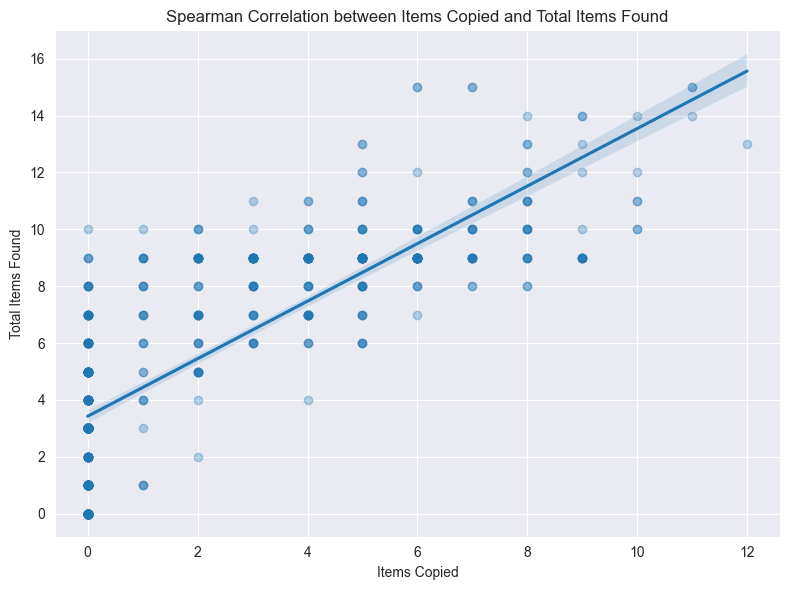

In [37]:
# Visualize the relationship with a scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='items_copied', y='total_items_found', data=df_combined, scatter_kws={'alpha':0.3})
plt.title('Spearman Correlation between Items Copied and Total Items Found')
plt.xlabel('Items Copied')
plt.ylabel('Total Items Found')
plt.tight_layout()

# Save the plot as a PDF file
output_path = "../../plots/interactions/scatter_plot_items_copied_total_items_found.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

### Relationship between copying behavior and total interactions

In [38]:
# Check normality
shapiro_total_interactions = shapiro(df_combined['total_interactions'])
print(f"Shapiro-Wilk test for total_interactions: {shapiro_total_interactions}")

if shapiro_total_interactions[1] < 0.05:
    print("The total_interactions is not normally distributed. Apply Spearman correlation.")
    # Calculate Spearman correlation
    spearman_corr_interactions, spearman_p_value_interactions = spearmanr(df_combined['items_copied'], df_combined['total_interactions'])
    print(f"Spearman correlation (total_interactions): {spearman_corr_interactions} (p-value: {spearman_p_value_interactions})")
else:
    print("The total_interactions is normally distributed. Apply Pearson correlation.")
    # Calculate Pearson correlation
    pearson_corr_interactions, pearson_p_value_interactions = pearsonr(df_combined['items_copied'], df_combined['total_interactions'])
    print(f"Pearson correlation (total_interactions): {pearson_corr_interactions} (p-value: {pearson_p_value_interactions})")

Shapiro-Wilk test for total_interactions: ShapiroResult(statistic=0.7238409327243048, pvalue=1.1559250006876533e-30)
The total_interactions is not normally distributed. Apply Spearman correlation.
Spearman correlation (total_interactions): 0.9234148655626551 (p-value: 1.5307941821648545e-257)


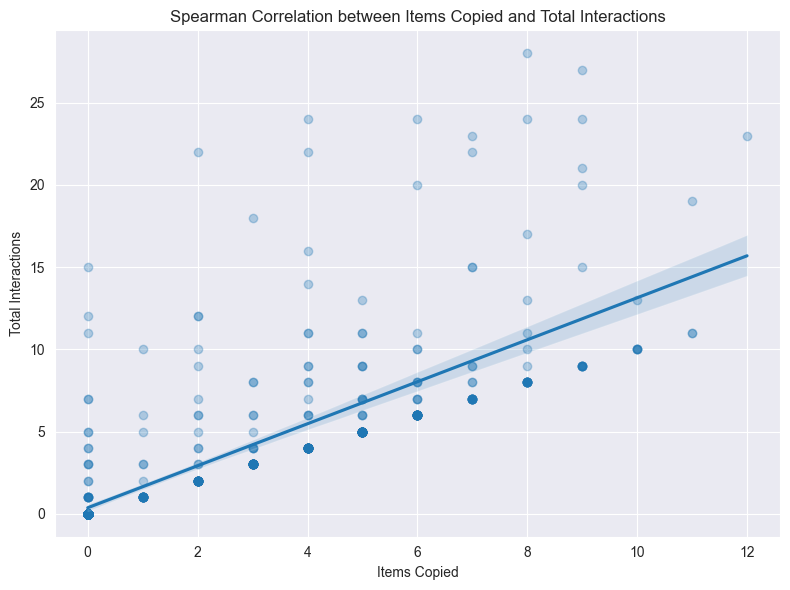

In [39]:
# Visualize the relationship with a scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='items_copied', y='total_interactions', data=df_combined, scatter_kws={'alpha':0.3})
plt.title('Spearman Correlation between Items Copied and Total Interactions')
plt.xlabel('Items Copied')
plt.ylabel('Total Interactions')
plt.tight_layout()

# Save the plot as a PDF file
output_path = "../../plots/interactions/scatter_plot_items_copied_total_interactions.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()